# Model Comparison

This notebook compares results from all 3 image-only experiments

(AI Assisted with helping generate scripts to create graphs)

In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

RESULTS_DIR = Path('results')

## Load All Results

In [27]:
def load_results():
    """Load all experiment results from JSON files"""
    models = ['vgg16', 'resnet50', 'efficientnet']
    data_modes = ['all', 'high_quality', 'brand_msrp_only']
    
    results = []
    for model in models:
        for mode in data_modes:
            json_path = RESULTS_DIR / model / f"{model}_{mode}_results.json"
            if json_path.exists():
                with open(json_path, 'r') as f:
                    data = json.load(f)
                    results.append({
                        'Model': model.upper() if model != 'efficientnet' else 'EfficientNetB0',
                        'Data Mode': mode.replace('_', ' ').title(),
                        'Test Accuracy': data['test_accuracy'],
                        'Test F1': data['test_f1'],
                        'Test Precision': data['test_precision'],
                        'Test Recall': data['test_recall'],
                        'Train Samples': data['train_samples'],
                        'Test Samples': data['test_samples']
                    })
    
    return pd.DataFrame(results)

df = load_results()
print("\n" + "="*80)
print("MODEL COMPARISON - ALL RESULTS")
print("="*80)
print(df.to_string(index=False))
print("="*80)


MODEL COMPARISON - ALL RESULTS
         Model       Data Mode  Test Accuracy  Test F1  Test Precision  Test Recall  Train Samples  Test Samples
         VGG16             All       0.596698 0.644860        0.576067     0.732311          13561          1696
         VGG16    High Quality       0.599222 0.655057        0.573944     0.762871          10276          1285
         VGG16 Brand Msrp Only       0.646199 0.684073        0.617925     0.766082           2736           342
      RESNET50             All       0.521226 0.672844        0.511016     0.984670          13561          1696
      RESNET50    High Quality       0.578988 0.676242        0.548544     0.881435          10276          1285
      RESNET50 Brand Msrp Only       0.652047 0.687664        0.623810     0.766082           2736           342
EfficientNetB0             All       0.578420 0.630109        0.561290     0.718160          13561          1696
EfficientNetB0    High Quality       0.585992 0.634615        0.

## Overall Performance Comparison

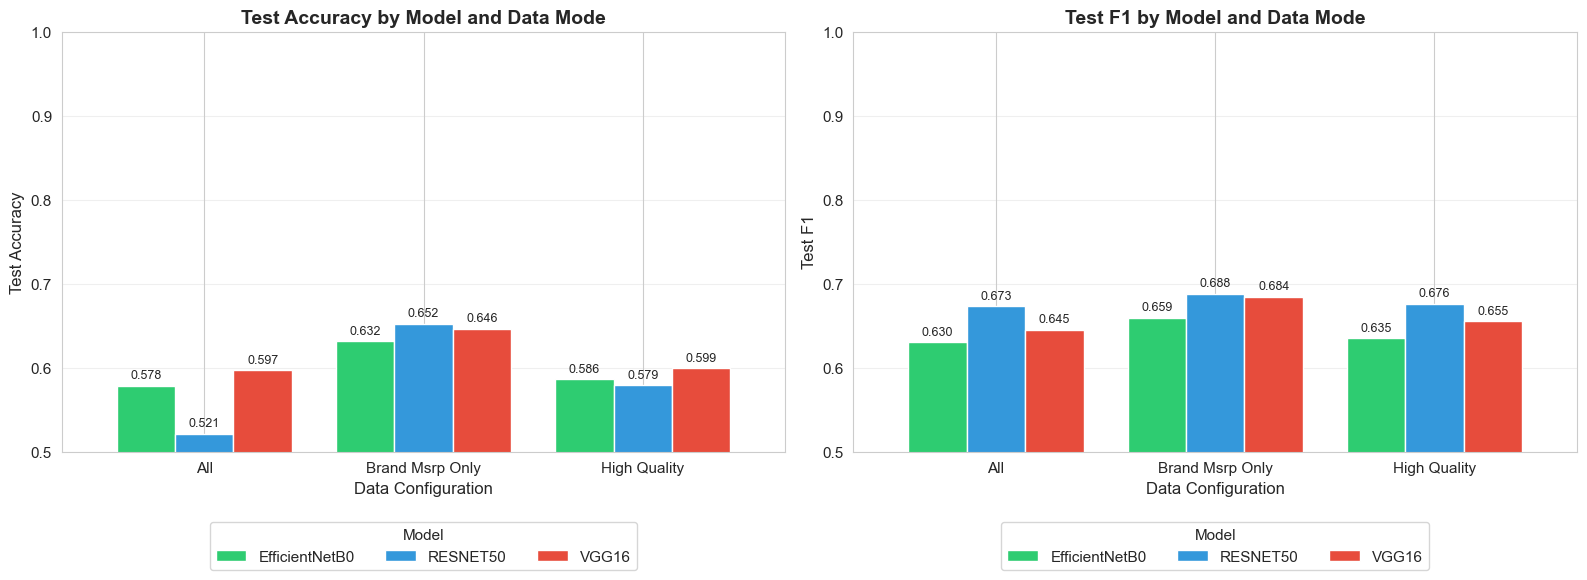

In [28]:
# Create grouped bar chart for accuracy and F1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
metrics = ['Test Accuracy', 'Test F1']
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    # Pivot data for grouped bar chart
    pivot_df = df.pivot(index='Data Mode', columns='Model', values=metric)
    
    # Plot
    pivot_df.plot(kind='bar', ax=ax, color=colors, width=0.8)
    ax.set_title(f'{metric} by Model and Data Mode', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Data Configuration', fontsize=12)
    ax.set_ylim([0.5, 1.0])
    ax.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('results/overall_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Performance vs Dataset Size

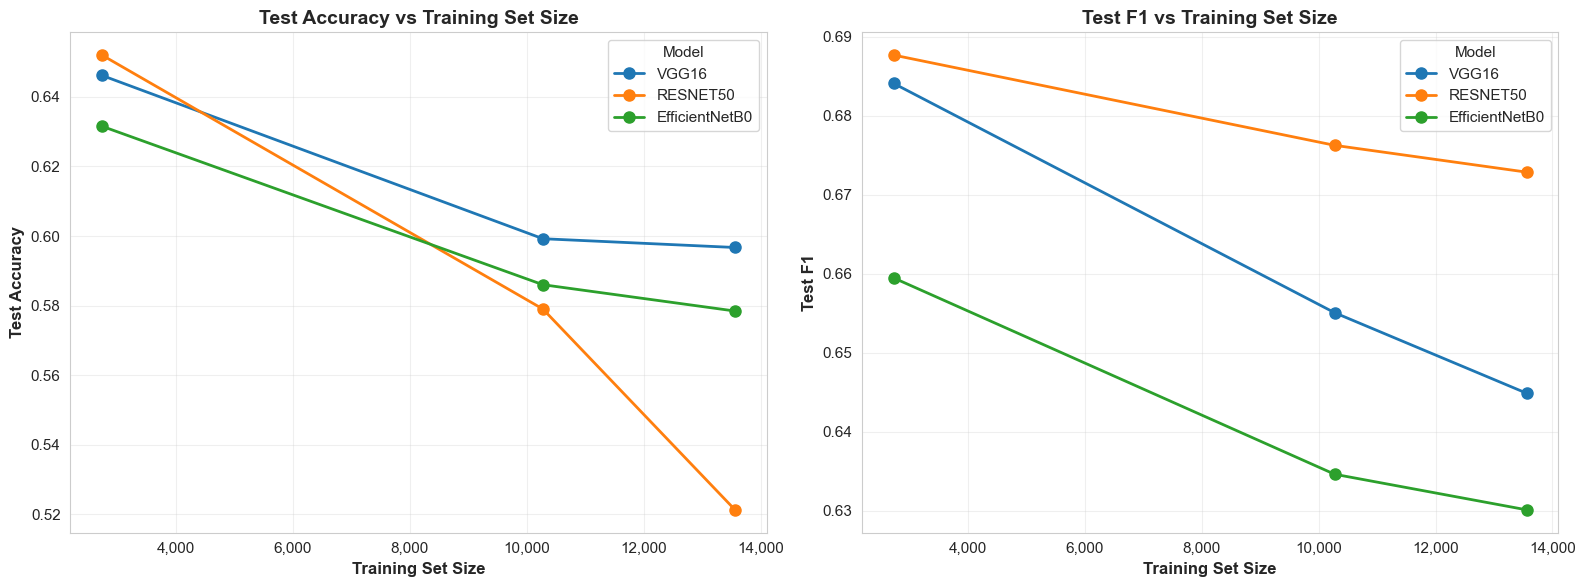

In [30]:
# Plot performance vs training set size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, metric in enumerate(['Test Accuracy', 'Test F1']):
    ax = axes[idx]
    
    for model in df['Model'].unique():
        model_data = df[df['Model'] == model].sort_values('Train Samples')
        ax.plot(model_data['Train Samples'], model_data[metric], 
                marker='o', linewidth=2, markersize=8, label=model)
    
    ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} vs Training Set Size', fontsize=14, fontweight='bold')
    ax.legend(title='Model', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis to show numbers with commas
    ax.ticklabel_format(style='plain', axis='x')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('results/performance_vs_dataset_size.png', dpi=300, bbox_inches='tight')
plt.show()

## Heatmap: Model Performance Across Data Modes

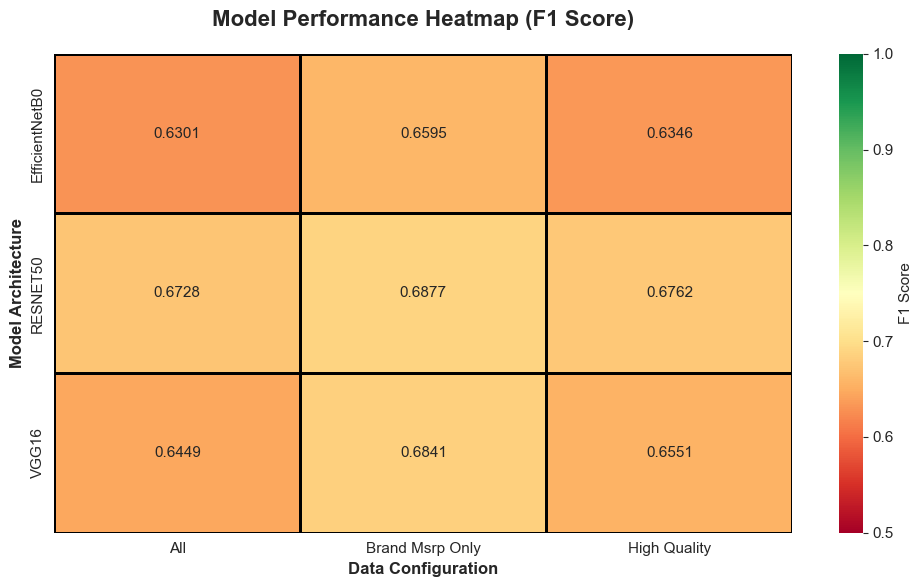

In [31]:
# Create heatmap for F1 scores
fig, ax = plt.subplots(figsize=(10, 6))

# Pivot data for heatmap
heatmap_data = df.pivot(index='Model', columns='Data Mode', values='Test F1')

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, cbar_kws={'label': 'F1 Score'},
            linewidths=1, linecolor='black', ax=ax)

ax.set_title('Model Performance Heatmap (F1 Score)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Model Architecture', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings Summary

In [32]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# 1. Best overall model
best_model = df.groupby('Model')['Test F1'].mean().idxmax()
print(f"\n1. Best Overall Model: {best_model}")

# 2. Best data configuration
best_config = df.groupby('Data Mode')['Test F1'].mean().idxmax()
print(f"2. Best Data Configuration: {best_config}")

# 3. Highest single performance
best_run = df.loc[df['Test F1'].idxmax()]
print(f"3. Best Single Run: {best_run['Model']} with {best_run['Data Mode']}")
print(f"   F1: {best_run['Test F1']:.4f}, Accuracy: {best_run['Test Accuracy']:.4f}")

# 4. Most consistent model (lowest std)
model_std = df.groupby('Model')['Test F1'].std()
most_consistent = model_std.idxmin()
print(f"4. Most Consistent Model: {most_consistent} (F1 std: {model_std.min():.4f})")

# 5. Impact of dataset size
correlation = df[['Train Samples', 'Test F1']].corr().iloc[0, 1]
print(f"5. Dataset Size Impact: Correlation with F1 = {correlation:.4f}")

print("\n" + "="*80)


KEY FINDINGS

1. Best Overall Model: RESNET50
2. Best Data Configuration: Brand Msrp Only
3. Best Single Run: RESNET50 with Brand Msrp Only
   F1: 0.6877, Accuracy: 0.6520
4. Most Consistent Model: RESNET50 (F1 std: 0.0078)
5. Dataset Size Impact: Correlation with F1 = -0.5974

